In [1]:
# @title Downloading necessary libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


# Price prediction for used cars

Welcome to the Kaggle competition for Playground Series - S4E9. In this notebook, we will walk through the end-to-end process of solving this competition. The steps include:

1. Understanding the problem and dataset.
2. Exploratory Data Analysis (EDA).
3. Data Preprocessing.
4. Model Training.
5. Hyperparameter Tuning.
6. Generating Predictions.
7. Submitting the results.

Let's get started!

## Problem Statement

The goal of this competition is to build a predictive model based on the provided dataset to optimize the performance metric. Key details include:

- **Train Dataset:** Contains features and target variable for training the model.
- **Test Dataset:** Contains only features for making predictions.
- **Submission Format:** A CSV file with predictions for the test data.

Our aim is to explore the data, preprocess it effectively, and build a model that performs well on the competition's evaluation metric.


## **Load and Understand the Data**

In this step:
1. **Import dataset using kaggle.json and competition name**
2. **Load the training and test datasets** using `pandas`.
3. Display the basic structure of the datasets:
   - The number of rows and columns in each dataset.
   - The first few rows of the datasets to understand the format and types of features.
4. Check the target variable (if present) and assess its characteristics, such as class balance.

In [2]:
# @title Import Data
#import data
from google.colab import files
files.upload()

# get json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# copy data file
!kaggle competitions download -c playground-series-s4e9
!unzip -q playground-series-s4e9.zip -d data

Saving kaggle.json to kaggle.json
 64% 5.00M/7.84M [00:00<00:00, 40.2MB/s]
100% 7.84M/7.84M [00:00<00:00, 46.0MB/s]


In [3]:
# @title Load the data
import pandas as pd
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
# @title Check the data
print(train.head())
print(train.info())
print(train.describe())

   id          brand              model  model_year  milage      fuel_type  \
0   0           MINI      Cooper S Base        2007  213000       Gasoline   
1   1        Lincoln              LS V8        2002  143250       Gasoline   
2   2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3   3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4   4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   
2                             A/T  

In [5]:
# @title check for shape and null values in test and train dataset
# Shape of the datasets
print("\nShape of Train Dataset:", train.shape)
print("Shape of Test Dataset:", test.shape)

# Check for missing values
print("\nMissing Values in Train Dataset:")
print(train.isnull().sum())

print("\nMissing Values in Test Dataset:")
print(test.isnull().sum())


Shape of Train Dataset: (188533, 13)
Shape of Test Dataset: (125690, 12)

Missing Values in Train Dataset:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

Missing Values in Test Dataset:
id                  0
brand               0
model               0
model_year          0
milage              0
fuel_type        3383
engine              0
transmission        0
ext_col             0
int_col             0
accident         1632
clean_title     14239
dtype: int64


In [6]:
print("Summary Statistics for Numerical Features in Train Dataset:")
print(train.describe())

Summary Statistics for Numerical Features in Train Dataset:
                  id     model_year         milage         price
count  188533.000000  188533.000000  188533.000000  1.885330e+05
mean    94266.000000    2015.829998   65705.295174  4.387802e+04
std     54424.933488       5.660967   49798.158076  7.881952e+04
min         0.000000    1974.000000     100.000000  2.000000e+03
25%     47133.000000    2013.000000   24115.000000  1.700000e+04
50%     94266.000000    2017.000000   57785.000000  3.082500e+04
75%    141399.000000    2020.000000   95400.000000  4.990000e+04
max    188532.000000    2024.000000  405000.000000  2.954083e+06


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125690 entries, 0 to 125689
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            125690 non-null  int64 
 1   brand         125690 non-null  object
 2   model         125690 non-null  object
 3   model_year    125690 non-null  int64 
 4   milage        125690 non-null  int64 
 5   fuel_type     122307 non-null  object
 6   engine        125690 non-null  object
 7   transmission  125690 non-null  object
 8   ext_col       125690 non-null  object
 9   int_col       125690 non-null  object
 10  accident      124058 non-null  object
 11  clean_title   111451 non-null  object
dtypes: int64(3), object(9)
memory usage: 11.5+ MB


## Step 3: Data Preprocessing

Data preprocessing involves preparing the data for modeling. Key steps include:

1. Handling missing values:
   - Imputing with mean/median for numerical columns.
   - Filling with mode or 'Unknown' for categorical columns.
   
2. Encoding categorical features:
   - Using Label Encoding for ordinal features.
   - Applying One-Hot Encoding for nominal features.

3. Scaling numerical features:
   - Standardizing or normalizing numerical columns to improve model performance.

4. Splitting data:
   - Splitting the dataset into training and validation sets for model evaluation.


In [8]:
# @title Convert datatype from object to string for column engine
train['engine'] = train['engine'].astype('string')
test['engine'] = test['engine'].astype('string')


In [9]:
# @title Convert datatype from object to string for column ext_col and int_col
train['ext_col'] = train['ext_col'].astype('string')
test['ext_col'] = test['ext_col'].astype('string')
train['int_col'] = train['int_col'].astype('string')
test['int_col'] = test['int_col'].astype('string')

In [10]:
# @title Convert datatype from object to string for column brand and model
train['brand'] = train['brand'].astype('string')
test['brand'] = test['brand'].astype('string')
train['model'] = train['model'].astype('string')
test['model'] = test['model'].astype('string')

In [11]:
# @title Convert datatype from object to string for column fuel_type
from sklearn.preprocessing import LabelEncoder
col_to_encode = ['fuel_type', 'accident', 'clean_title']
for col in col_to_encode:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [12]:
# @title Convert transmission column datatype to string
train['transmission'] = train['transmission'].astype('string')
test['transmission'] = test['transmission'].astype('string')

## Step 2: Exploratory Data Analysis (EDA)

EDA helps us understand the dataset, its features, and their relationships with the target variable. Key steps include:

1. Viewing the data structure (columns, types, missing values).
2. Checking the distribution of the target variable.
3. Analyzing numerical and categorical features.
4. Identifying correlations between features.
5. Visualizing relationships to extract insights.

By the end of this step, we'll have a clear idea of the dataset's characteristics.

price Variable Distribution:
price
15000     1920
12000     1459
30000     1280
29000     1228
8500      1204
          ... 
239991      22
269991      22
259991      21
107998      20
45998       19
Name: count, Length: 1569, dtype: int64


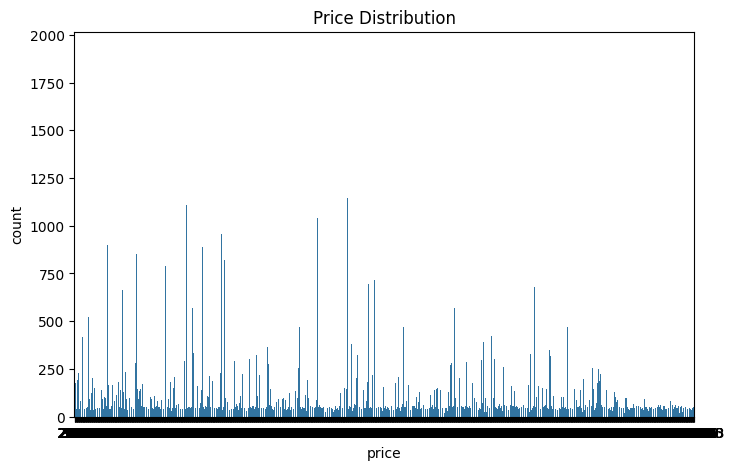

In [13]:
# @title Distribution of price feature
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Count the price feature distribution
print("price Variable Distribution:")
print(train["price"].value_counts())
plt.figure(figsize=(8, 5))
sns.countplot(x="price", data=train)
plt.title("Price Distribution")
plt.show()

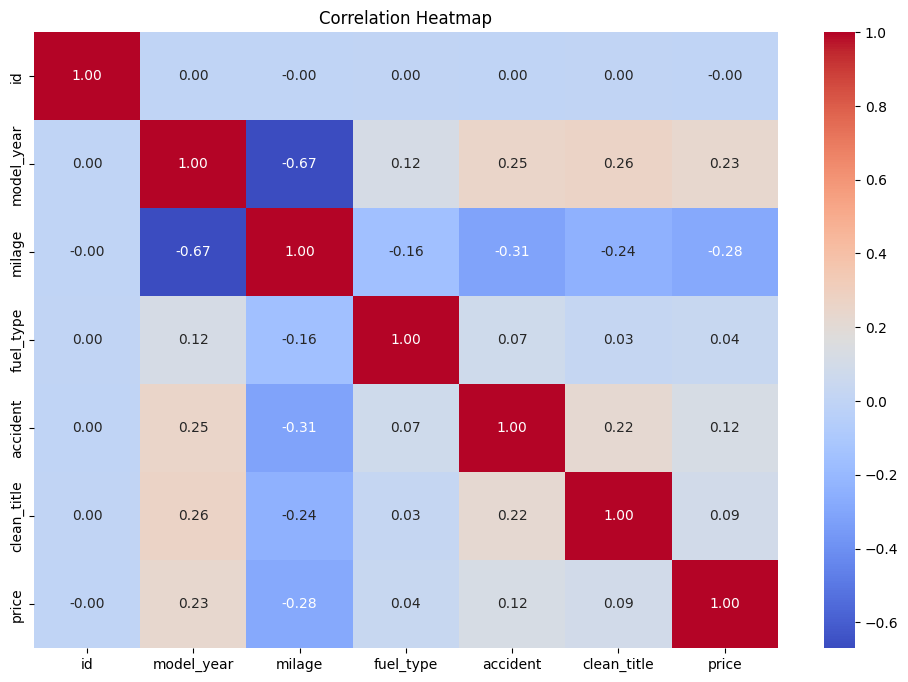

In [14]:
# @title correlation heatmap
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
# Select only numerical features for correlation calculation
numerical_features = train.select_dtypes(include=np.number).columns
corr_matrix = train[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [23]:
# @title Split the training data between training and validation dataset
from sklearn.model_selection import train_test_split
# Identify string columns
string_cols = train.select_dtypes(include=['object', 'string']).columns
# Drop string columns from train and store that into X
X = train.drop(columns=string_cols)
# drop price column
X = X.drop("price", axis=1)
y = train["price"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


## Step 4: Model Training

In this step, we'll train multiple machine learning models to predict the target variable. Steps include:

1. Splitting the data into training and validation sets.
2. Selecting baseline models such as Logistic Regression, Decision Trees, or Random Forests.
3. Evaluating the performance of models using metrics such as accuracy or AUC-ROC.
4. Choosing advanced models like XGBoost, LightGBM, or CatBoost to optimize performance.

In [24]:
# @title Model training
from xgboost import XGBRegressor # Change to XGBRegressor for regression tasks
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# @title Model evaluation
from sklearn.metrics import mean_squared_error, r2_score # Import regression metrics
y_pred = model.predict(X_valid)
# calculate regression metrics mse and r2
mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Squared Error: 5504743323.487425
R-squared: 0.010140419006347656


In [30]:
y_pred

array([53157.54 , 35857.832, 38091.934, ..., 24602.623, 16975.852,
       30775.049], dtype=float32)

## Step 5: Hyperparameter Tuning

Hyperparameter tuning involves finding the best parameters for the model to improve its performance. We'll:

1. Use Grid Search or Random Search to explore a range of hyperparameter values.
2. Implement Bayesian optimization using libraries like Optuna for efficient tuning.
3. Evaluate the tuned model on validation data to ensure improvement.

In [ ]:
# @title Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

## Step 6: Generating Predictions

After finalizing the model, we'll use it to make predictions on the test dataset. Steps include:

1. Loading the test dataset.
2. Preprocessing the test data using the same steps as the training data.
3. Generating predictions for the test dataset.
4. Saving the predictions in the format specified by the competition.

In [34]:
# @title Result generation
# Identify string columns
string_cols = test.select_dtypes(include=['object', 'string']).columns
# Drop string columns from test and use that to predict car price
test_preds = model.predict(test.drop(columns=string_cols))
submission = pd.DataFrame({
    "id": test["id"],  # Replace "Id" with the appropriate column
    "price": test_preds  # Replace "target" with the actual target column
})
submission.to_csv("submission.csv", index=False)
